필요한 모듈 임포트

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import platform
plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
if platform.system() == 'Windows': # 윈도우
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
    # !sudo apt-get install -y fonts-nanum*
    # !fc-cache -fv
    
    applyfont = "NanumBarunGothic"
    import matplotlib.font_manager as fm
    if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
        fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
    plt.rc("font", family=applyfont)
    plt.rc("axes", unicode_minus=False)

In [3]:
# GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [4]:
from sklearn.preprocessing import StandardScaler

데이터 가져오기

In [5]:
base_path = r"C:\Users\owner\Desktop\water-source\data"

In [6]:
jsb_yearly = pd.read_excel(base_path+"\Jugsanbo.xlsx", 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col = 0을 제외함

In [7]:
print(type(jsb_yearly))  # type-dict
print(jsb_yearly.keys())  # 2012년부터 2022년까지

<class 'dict'>
dict_keys(['2012년', '2013년', '2014년', '2015년', '2016년', '2017년', '2018년', '2019년', '2020년', '2021년', '2022년'])


In [8]:
jsb_yearly['2012년'].columns

Index(['측정일/월', '측정소명', '수온 ℃', '수소이온농도', '전기전도도 μS/cm', '용존산소 mg/L', '탁도 NTU',
       '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥'],
      dtype='object')

2013년 자료부터

In [9]:
jsb_yearly_df13 = pd.DataFrame()

for item in list(jsb_yearly.keys())[1:]:
    jsb_yearly_df13 = pd.concat([jsb_yearly_df13, jsb_yearly[item]])

In [10]:
jsb_yearly_df13 = jsb_yearly_df13.reset_index(drop=True)

결측치 확인

In [11]:
jsb_yearly_df13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82064 entries, 0 to 82063
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82064 non-null  object 
 1   측정소명         82064 non-null  object 
 2   수온 ℃         71955 non-null  float64
 3   수소이온농도       72092 non-null  float64
 4   전기전도도 μS/cm  72139 non-null  float64
 5   용존산소 mg/L    70998 non-null  float64
 6   탁도 NTU       71312 non-null  float64
 7   총유기탄소 mg/L   66051 non-null  float64
 8   총질소 mg/L     67124 non-null  float64
 9   총인 mg/L      67772 non-null  float64
 10  클로로필-a mg/㎥  69643 non-null  float64
dtypes: float64(9), object(2)
memory usage: 6.9+ MB


In [12]:
jsb_yearly_df13.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           10109
수소이온농도          9972
전기전도도 μS/cm     9925
용존산소 mg/L      11066
탁도 NTU         10752
총유기탄소 mg/L     16013
총질소 mg/L       14940
총인 mg/L        14292
클로로필-a mg/㎥    12421
dtype: int64

In [13]:
jsb_yearly_df13.head()

,측정일/월,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,탁도 NTU,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00h,나주,3.3,6.8,272.0,12.0,1.8,1.9,NaN,NaN,12.2
1,2013-01-01 01h,나주,3.1,6.7,272.0,12.0,1.7,1.9,NaN,NaN,12.0
2,2013-01-01 02h,나주,3.0,6.7,273.0,12.0,1.7,1.9,NaN,NaN,12.1
3,2013-01-01 03h,나주,3.0,6.7,275.0,12.0,1.6,1.9,NaN,NaN,12.2
4,2013-01-01 04h,나주,2.9,6.7,276.0,12.0,1.5,1.9,NaN,NaN,12.1


유량 데이터 추가하기

In [14]:
jsb_flow_yearly = pd.read_excel(base_path+"\Jugsanbo_flow.xlsx", 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col = 0을 제외함

In [15]:
for year in list(jsb_flow_yearly.keys())[1:]:
    jsb_flow_yearly[year]['연월일시'] = jsb_flow_yearly[year]['시간'].apply(lambda x : x[:-3])

In [16]:
jsb_flow_yearly_hour = {}

for year in list(jsb_flow_yearly.keys())[1:]:
    jsb_flow_yearly_hour[year] = jsb_flow_yearly[year].groupby('연월일시').mean()

In [17]:
for year in jsb_flow_yearly_hour:
    jsb_flow_yearly_hour[year] = jsb_flow_yearly_hour[year].reset_index()

In [18]:
jsb_flow_yearly_hour_df = pd.DataFrame()

for year in jsb_flow_yearly_hour:
    jsb_flow_yearly_hour_df = pd.concat([jsb_flow_yearly_hour_df, jsb_flow_yearly_hour[year]])

In [19]:
jsb_flow_yearly_hour_df = jsb_flow_yearly_hour_df.reset_index(drop=True)

In [20]:
print(jsb_flow_yearly_hour_df.__len__())
print(jsb_yearly_df13.__len__())

84462
82064


In [21]:
jsb_yearly_df13['연월일시'] = jsb_yearly_df13['측정일/월'].transform(lambda x: x.strip('h').replace('-', '.'))

In [22]:
jsb_data = pd.merge(jsb_yearly_df13, jsb_flow_yearly_hour_df, how='outer')

In [23]:
jsb_data = jsb_data[:82064]

In [24]:
jsb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82064 entries, 0 to 82063
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82064 non-null  object 
 1   측정소명         82064 non-null  object 
 2   수온 ℃         71955 non-null  float64
 3   수소이온농도       72092 non-null  float64
 4   전기전도도 μS/cm  72139 non-null  float64
 5   용존산소 mg/L    70998 non-null  float64
 6   탁도 NTU       71312 non-null  float64
 7   총유기탄소 mg/L   66051 non-null  float64
 8   총질소 mg/L     67124 non-null  float64
 9   총인 mg/L      67772 non-null  float64
 10  클로로필-a mg/㎥  69643 non-null  float64
 11  연월일시         82064 non-null  object 
 12   상류수위(EL.m)  82051 non-null  float64
 13   하류수위(EL.m)  82051 non-null  float64
 14   유입량(㎥/s)    82051 non-null  float64
 15   방류량(㎥/s)    82051 non-null  float64
dtypes: float64(13), object(3)
memory usage: 10.6+ MB


In [25]:
jsb_data.columns = [x.strip() for x in list(jsb_data.columns)]

In [26]:
jsb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82064 entries, 0 to 82063
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82064 non-null  object 
 1   측정소명         82064 non-null  object 
 2   수온 ℃         71955 non-null  float64
 3   수소이온농도       72092 non-null  float64
 4   전기전도도 μS/cm  72139 non-null  float64
 5   용존산소 mg/L    70998 non-null  float64
 6   탁도 NTU       71312 non-null  float64
 7   총유기탄소 mg/L   66051 non-null  float64
 8   총질소 mg/L     67124 non-null  float64
 9   총인 mg/L      67772 non-null  float64
 10  클로로필-a mg/㎥  69643 non-null  float64
 11  연월일시         82064 non-null  object 
 12  상류수위(EL.m)   82051 non-null  float64
 13  하류수위(EL.m)   82051 non-null  float64
 14  유입량(㎥/s)     82051 non-null  float64
 15  방류량(㎥/s)     82051 non-null  float64
dtypes: float64(13), object(3)
memory usage: 10.6+ MB


In [27]:
jsb_data = jsb_data.loc[:, list(jsb_data.columns)[:3]  + list(jsb_data.columns)[4:5] + list(jsb_data.columns)[6:-5] + list(jsb_data.columns)[-4:-3] + list(jsb_data.columns)[-1:]]

In [28]:
jsb_data.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L',
       '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

In [29]:
jsb_data.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           10109
전기전도도 μS/cm     9925
탁도 NTU         10752
총유기탄소 mg/L     16013
총질소 mg/L       14940
총인 mg/L        14292
클로로필-a mg/㎥    12421
상류수위(EL.m)        13
방류량(㎥/s)          13
dtype: int64

In [30]:
jsb_data.isnull().sum() /len(jsb_data)

측정일/월          0.000000
측정소명           0.000000
수온 ℃           0.123184
전기전도도 μS/cm    0.120942
탁도 NTU         0.131020
총유기탄소 mg/L     0.195128
총질소 mg/L       0.182053
총인 mg/L        0.174157
클로로필-a mg/㎥    0.151357
상류수위(EL.m)     0.000158
방류량(㎥/s)       0.000158
dtype: float64

In [31]:
len(jsb_data)

82064

시간데이터 추가

In [32]:
jsb_df = jsb_data.copy()

In [33]:
jsb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L',
       '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

In [34]:
col_c = list(jsb_df.columns.copy())
col_c.remove('클로로필-a mg/㎥')

In [35]:
col_c

['측정일/월',
 '측정소명',
 '수온 ℃',
 '전기전도도 μS/cm',
 '탁도 NTU',
 '총유기탄소 mg/L',
 '총질소 mg/L',
 '총인 mg/L',
 '상류수위(EL.m)',
 '방류량(㎥/s)']

In [36]:
for i in range(1, 49):
    jsb_df[str(i) + 'shift 전기전도도'] = jsb_df['전기전도도 μS/cm'].shift(i)

In [37]:
len(jsb_df)

82064

In [38]:
jsb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L',
       '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)',
       '1shift 전기전도도', '2shift 전기전도도', '3shift 전기전도도', '4shift 전기전도도',
       '5shift 전기전도도', '6shift 전기전도도', '7shift 전기전도도', '8shift 전기전도도',
       '9shift 전기전도도', '10shift 전기전도도', '11shift 전기전도도', '12shift 전기전도도',
       '13shift 전기전도도', '14shift 전기전도도', '15shift 전기전도도', '16shift 전기전도도',
       '17shift 전기전도도', '18shift 전기전도도', '19shift 전기전도도', '20shift 전기전도도',
       '21shift 전기전도도', '22shift 전기전도도', '23shift 전기전도도', '24shift 전기전도도',
       '25shift 전기전도도', '26shift 전기전도도', '27shift 전기전도도', '28shift 전기전도도',
       '29shift 전기전도도', '30shift 전기전도도', '31shift 전기전도도', '32shift 전기전도도',
       '33shift 전기전도도', '34shift 전기전도도', '35shift 전기전도도', '36shift 전기전도도',
       '37shift 전기전도도', '38shift 전기전도도', '39shift 전기전도도', '40shift 전기전도도',
       '41shift 전기전도도', '42shift 전기전도도', '43shift 전기전도도', '44shift 전기전도도',
       '45shift 전기전도도', '46shift 전기전도도', '

In [39]:
len(jsb_df)

82064

결측치 보간법

In [40]:
from datetime import datetime

In [41]:
jsb_df = jsb_df.copy()

In [42]:
jsb_df['측정일/월'] = jsb_df['측정일/월'].transform(lambda x: datetime.strptime(x[:-1], '%Y-%m-%d %H'))

In [43]:
jsb_df = jsb_df.copy().set_index('측정일/월').interpolate(method='time')

In [44]:
jsb_df = jsb_df.dropna()

In [45]:
jsb_df.__len__()

79963

In [46]:
jsb_df.columns

Index(['측정소명', '수온 ℃', '전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', '1shift 전기전도도',
       '2shift 전기전도도', '3shift 전기전도도', '4shift 전기전도도', '5shift 전기전도도',
       '6shift 전기전도도', '7shift 전기전도도', '8shift 전기전도도', '9shift 전기전도도',
       '10shift 전기전도도', '11shift 전기전도도', '12shift 전기전도도', '13shift 전기전도도',
       '14shift 전기전도도', '15shift 전기전도도', '16shift 전기전도도', '17shift 전기전도도',
       '18shift 전기전도도', '19shift 전기전도도', '20shift 전기전도도', '21shift 전기전도도',
       '22shift 전기전도도', '23shift 전기전도도', '24shift 전기전도도', '25shift 전기전도도',
       '26shift 전기전도도', '27shift 전기전도도', '28shift 전기전도도', '29shift 전기전도도',
       '30shift 전기전도도', '31shift 전기전도도', '32shift 전기전도도', '33shift 전기전도도',
       '34shift 전기전도도', '35shift 전기전도도', '36shift 전기전도도', '37shift 전기전도도',
       '38shift 전기전도도', '39shift 전기전도도', '40shift 전기전도도', '41shift 전기전도도',
       '42shift 전기전도도', '43shift 전기전도도', '44shift 전기전도도', '45shift 전기전도도',
       '46shift 전기전도도', '47shift 전

In [47]:
col = list(jsb_df.columns[2:])
print(col)

['전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', '1shift 전기전도도', '2shift 전기전도도', '3shift 전기전도도', '4shift 전기전도도', '5shift 전기전도도', '6shift 전기전도도', '7shift 전기전도도', '8shift 전기전도도', '9shift 전기전도도', '10shift 전기전도도', '11shift 전기전도도', '12shift 전기전도도', '13shift 전기전도도', '14shift 전기전도도', '15shift 전기전도도', '16shift 전기전도도', '17shift 전기전도도', '18shift 전기전도도', '19shift 전기전도도', '20shift 전기전도도', '21shift 전기전도도', '22shift 전기전도도', '23shift 전기전도도', '24shift 전기전도도', '25shift 전기전도도', '26shift 전기전도도', '27shift 전기전도도', '28shift 전기전도도', '29shift 전기전도도', '30shift 전기전도도', '31shift 전기전도도', '32shift 전기전도도', '33shift 전기전도도', '34shift 전기전도도', '35shift 전기전도도', '36shift 전기전도도', '37shift 전기전도도', '38shift 전기전도도', '39shift 전기전도도', '40shift 전기전도도', '41shift 전기전도도', '42shift 전기전도도', '43shift 전기전도도', '44shift 전기전도도', '45shift 전기전도도', '46shift 전기전도도', '47shift 전기전도도', '48shift 전기전도도']


In [48]:
col_v = col.copy()
col_v.remove('클로로필-a mg/㎥')
print(col_v)

['전기전도도 μS/cm', '탁도 NTU', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '상류수위(EL.m)', '방류량(㎥/s)', '1shift 전기전도도', '2shift 전기전도도', '3shift 전기전도도', '4shift 전기전도도', '5shift 전기전도도', '6shift 전기전도도', '7shift 전기전도도', '8shift 전기전도도', '9shift 전기전도도', '10shift 전기전도도', '11shift 전기전도도', '12shift 전기전도도', '13shift 전기전도도', '14shift 전기전도도', '15shift 전기전도도', '16shift 전기전도도', '17shift 전기전도도', '18shift 전기전도도', '19shift 전기전도도', '20shift 전기전도도', '21shift 전기전도도', '22shift 전기전도도', '23shift 전기전도도', '24shift 전기전도도', '25shift 전기전도도', '26shift 전기전도도', '27shift 전기전도도', '28shift 전기전도도', '29shift 전기전도도', '30shift 전기전도도', '31shift 전기전도도', '32shift 전기전도도', '33shift 전기전도도', '34shift 전기전도도', '35shift 전기전도도', '36shift 전기전도도', '37shift 전기전도도', '38shift 전기전도도', '39shift 전기전도도', '40shift 전기전도도', '41shift 전기전도도', '42shift 전기전도도', '43shift 전기전도도', '44shift 전기전도도', '45shift 전기전도도', '46shift 전기전도도', '47shift 전기전도도', '48shift 전기전도도']


피처 정규화 없이

In [49]:
X_train, X_test, y_train, y_test = train_test_split(jsb_df.loc[:, col_v], jsb_df['클로로필-a mg/㎥'], random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [50]:
gb_grid = GridSearchCV(gb_reg, param_grid=parameters, cv=3)

In [51]:
gb_grid.fit(X_train, np.log1p(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]})

In [52]:
scores_df = pd.DataFrame(gb_grid.cv_results_)

In [53]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.942152,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.941560,2
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.940074,3
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.928650,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.916326,5


In [54]:
gb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [55]:
estimator = gb_grid.best_estimator_

In [56]:
pred = estimator.predict(X_test)

In [57]:
for score, name in zip(estimator.feature_importances_, col_v):
    print(round(score, 2), name)

0.06 전기전도도 μS/cm
0.09 탁도 NTU
0.19 총유기탄소 mg/L
0.16 총질소 mg/L
0.1 총인 mg/L
0.13 상류수위(EL.m)
0.06 방류량(㎥/s)
0.01 1shift 전기전도도
0.01 2shift 전기전도도
0.01 3shift 전기전도도
0.01 4shift 전기전도도
0.0 5shift 전기전도도
0.0 6shift 전기전도도
0.0 7shift 전기전도도
0.0 8shift 전기전도도
0.0 9shift 전기전도도
0.0 10shift 전기전도도
0.0 11shift 전기전도도
0.0 12shift 전기전도도
0.0 13shift 전기전도도
0.0 14shift 전기전도도
0.0 15shift 전기전도도
0.0 16shift 전기전도도
0.0 17shift 전기전도도
0.0 18shift 전기전도도
0.0 19shift 전기전도도
0.0 20shift 전기전도도
0.0 21shift 전기전도도
0.0 22shift 전기전도도
0.0 23shift 전기전도도
0.0 24shift 전기전도도
0.0 25shift 전기전도도
0.0 26shift 전기전도도
0.0 27shift 전기전도도
0.0 28shift 전기전도도
0.0 29shift 전기전도도
0.0 30shift 전기전도도
0.0 31shift 전기전도도
0.0 32shift 전기전도도
0.0 33shift 전기전도도
0.0 34shift 전기전도도
0.0 35shift 전기전도도
0.0 36shift 전기전도도
0.0 37shift 전기전도도
0.0 38shift 전기전도도
0.0 39shift 전기전도도
0.01 40shift 전기전도도
0.0 41shift 전기전도도
0.0 42shift 전기전도도
0.0 43shift 전기전도도
0.0 44shift 전기전도도
0.0 45shift 전기전도도
0.01 46shift 전기전도도
0.01 47shift 전기전도도
0.02 48shift 전기전도도


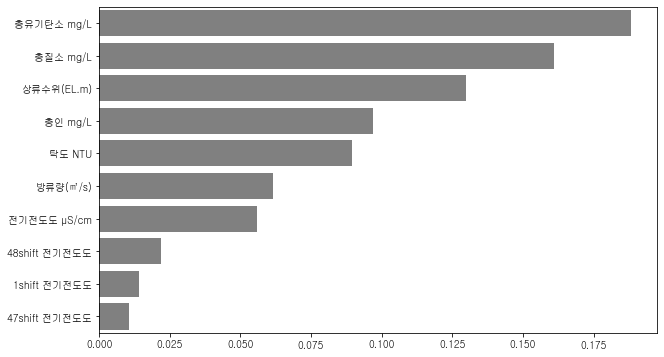

In [58]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col_v)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [59]:
print('score :', estimator.score(X_test, np.log1p(y_test)))

score : 0.9593056476265716


In [60]:
feature_series[:10]

총유기탄소 mg/L       0.188079
총질소 mg/L         0.160995
상류수위(EL.m)       0.129851
총인 mg/L          0.096925
탁도 NTU           0.089568
방류량(㎥/s)         0.061670
전기전도도 μS/cm      0.055818
48shift 전기전도도    0.021890
1shift 전기전도도     0.014199
47shift 전기전도도    0.010471
dtype: float64

피처 정규화

In [61]:
scaler = StandardScaler()
scaler.fit(jsb_df.loc[:, col_v])
jsb_scaled = scaler.transform(jsb_df.loc[:, col_v])

jsb_df_scaled = pd.DataFrame(data = jsb_scaled, columns = col_v)

In [62]:
jsb_df_scaled.head()

,전기전도도 μS/cm,탁도 NTU,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,상류수위(EL.m),방류량(㎥/s),1shift 전기전도도,2shift 전기전도도,3shift 전기전도도,...,39shift 전기전도도,40shift 전기전도도,41shift 전기전도도,42shift 전기전도도,43shift 전기전도도,44shift 전기전도도,45shift 전기전도도,46shift 전기전도도,47shift 전기전도도,48shift 전기전도도
0,-1.198346,0.044874,-0.355037,-0.555441,1.071211,0.526046,-0.277792,-1.215034,-1.231694,-1.253953,...,-1.319497,-1.319462,-1.330560,-1.341660,-1.341622,-1.330452,-1.330413,-1.319245,-1.319210,-1.319176
1,-1.187208,0.062630,-0.355037,-0.518827,1.131865,0.552987,-0.277792,-1.198326,-1.214986,-1.231676,...,-1.319497,-1.319462,-1.319426,-1.330526,-1.341622,-1.341586,-1.330413,-1.330379,-1.319210,-1.319176
2,-1.198346,0.074467,-0.355037,-0.530421,1.192519,0.552987,-0.277792,-1.187188,-1.198279,-1.214968,...,-1.319497,-1.319462,-1.319426,-1.319391,-1.330487,-1.341586,-1.341547,-1.330379,-1.330344,-1.319176
3,-1.198346,0.098142,-0.254360,-0.513335,1.172301,0.571845,-0.277792,-1.198326,-1.187140,-1.198261,...,-1.319497,-1.319462,-1.319426,-1.319391,-1.319353,-1.330452,-1.341547,-1.341513,-1.330344,-1.330309
4,-1.187208,0.157330,-0.254360,-0.480383,1.192519,0.577233,-0.277792,-1.198326,-1.198279,-1.187123,...,-1.319497,-1.319462,-1.319426,-1.319391,-1.319353,-1.319318,-1.330413,-1.341513,-1.341478,-1.330309


In [63]:
X_trains, X_tests, y_trains, y_tests = train_test_split(jsb_df_scaled.loc[:, col_v], jsb_df['클로로필-a mg/㎥'], random_state=42)
gb_regs = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [64]:
gb_grids = GridSearchCV(gb_regs, param_grid=parameters, cv=3)

In [65]:
gb_grids.fit(X_trains, np.log1p(y_trains))

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]})

In [66]:
scores_dfs = pd.DataFrame(gb_grids.cv_results_)

In [67]:
scores_dfs.sort_values(by=['rank_test_score'], inplace=True)
scores_dfs[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.942177,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.941546,2
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.940173,3
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.928636,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.916294,5


In [68]:
gb_grids.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [69]:
estimators = gb_grids.best_estimator_

In [70]:
preds = estimators.predict(X_tests)

In [71]:
for score, name in zip(estimators.feature_importances_, col_v):
    print(round(score, 2), name)

0.06 전기전도도 μS/cm
0.09 탁도 NTU
0.19 총유기탄소 mg/L
0.16 총질소 mg/L
0.1 총인 mg/L
0.13 상류수위(EL.m)
0.06 방류량(㎥/s)
0.01 1shift 전기전도도
0.01 2shift 전기전도도
0.01 3shift 전기전도도
0.01 4shift 전기전도도
0.0 5shift 전기전도도
0.0 6shift 전기전도도
0.0 7shift 전기전도도
0.0 8shift 전기전도도
0.0 9shift 전기전도도
0.0 10shift 전기전도도
0.0 11shift 전기전도도
0.0 12shift 전기전도도
0.0 13shift 전기전도도
0.0 14shift 전기전도도
0.0 15shift 전기전도도
0.0 16shift 전기전도도
0.0 17shift 전기전도도
0.0 18shift 전기전도도
0.0 19shift 전기전도도
0.0 20shift 전기전도도
0.0 21shift 전기전도도
0.0 22shift 전기전도도
0.0 23shift 전기전도도
0.0 24shift 전기전도도
0.0 25shift 전기전도도
0.0 26shift 전기전도도
0.0 27shift 전기전도도
0.0 28shift 전기전도도
0.0 29shift 전기전도도
0.0 30shift 전기전도도
0.0 31shift 전기전도도
0.0 32shift 전기전도도
0.0 33shift 전기전도도
0.0 34shift 전기전도도
0.0 35shift 전기전도도
0.0 36shift 전기전도도
0.0 37shift 전기전도도
0.0 38shift 전기전도도
0.0 39shift 전기전도도
0.01 40shift 전기전도도
0.0 41shift 전기전도도
0.0 42shift 전기전도도
0.0 43shift 전기전도도
0.0 44shift 전기전도도
0.0 45shift 전기전도도
0.01 46shift 전기전도도
0.01 47shift 전기전도도
0.02 48shift 전기전도도


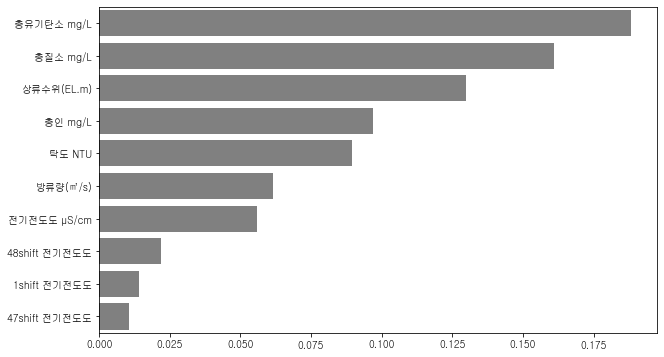

In [72]:
feature_seriess = pd.Series(data = estimators.feature_importances_, index = col_v)
feature_seriess = feature_seriess.sort_values(ascending = False)
sns.barplot(x = feature_seriess[:10], y = feature_seriess.index[:10], color = 'gray')
plt.show()

In [73]:
print('score :', estimators.score(X_tests, np.log1p(y_tests)))

score : 0.959245848924028


In [74]:
feature_series[:10]

총유기탄소 mg/L       0.188079
총질소 mg/L         0.160995
상류수위(EL.m)       0.129851
총인 mg/L          0.096925
탁도 NTU           0.089568
방류량(㎥/s)         0.061670
전기전도도 μS/cm      0.055818
48shift 전기전도도    0.021890
1shift 전기전도도     0.014199
47shift 전기전도도    0.010471
dtype: float64